In [140]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from collections import Counter
import string
import re

# Import user defined functions.
import parse as prs

# Read and parse json.
df = pd.read_json('data/train.json')

# Defining names of the target
target_names = ['high','medium','low']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# Reducing the dataframe
#rows = np.random.choice(df.index.values, 1000)
#sampled_df = df.ix[rows]
#df = sampled_df

In [89]:
# Looking at the dataframe
rows = np.random.choice(df.index.values, 3)
sampled_df = df.ix[rows]
sampled_df

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
4698,2.0,3,c9b5ba9bc3196fa92db7a662db0259e8,2016-06-06 10:29:51,"NO FEE\r\rLuxury apartment offers studio, alco...",,"[Laundry In Unit, Cats Allowed, Private Outdoo...",low,40.7070,7116549,-74.0052,524a48d3526730bec7262442b3aa9a94,[https://photos.renthop.com/2/7116549_d6dddea3...,7929,70 pine street
56565,2.0,2,4536d999c24c6f4723a5c1ce3e17860b,2016-05-19 01:50:15,,Horatio Street,"[Doorman, Prewar, Fitness Center, Elevator, Ga...",low,40.7389,7035426,-74.0088,62b685cc0d876c3a1a51d63a0d6a8082,[],9000,95-97 HORATIO Street
96815,2.0,3,7e146ee3b917175e529547c501de037a,2016-04-05 04:44:35,GORGEOUS Conv/3 Bedroom duplex! This is a newl...,E 82nd St,[],low,40.7729,6825277,-73.9484,2827fb427270169c5024c44cf966f71b,[https://photos.renthop.com/2/6825277_1cb595da...,3900,510 E 82nd St


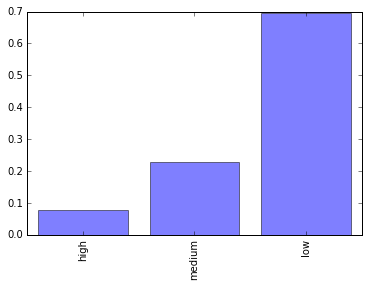

In [68]:
# Proportion of interest level.
prop_interest = []
for interest_name in target_names:
   prop_interest.append(np.float(np.sum(df.interest_level==interest_name))/np.float(np.shape(df)[0]))

# Plotting as graph bar.
y_pos = np.arange(len(target_names))
plt.bar(y_pos, prop_interest, align='center', alpha=0.5)
plt.xticks(y_pos, target_names, rotation='vertical') 
plt.show()

In [69]:
# Looking at the most common features in an subset
size_subset = 100
n_features = 10
rows = np.random.choice(df.index.values, size_subset)
sampled_features = df["features"].ix[rows]
allFeatures=[]
for row in rows:
    allFeatures.extend(sampled_features.loc[[row]].values[0])
     #   allFeatures.extend(map(lambda x:x.lower(),sampled_features.loc[[row]].values[0]))
features_to_count = (word for word in allFeatures if word[:1])
features_count = Counter(features_to_count)
common_features = map(lambda x:x[0],features_count.most_common(n_features))
common_features_rows= map(lambda x:'with_'+x.lower().replace(" ","_"),common_features)
print(common_features_rows)

[u'with_cats_allowed', u'with_dogs_allowed', u'with_elevator', u'with_dishwasher', u'with_no_fee', u'with_hardwood_floors', u'with_doorman', u'with_laundry_in_building', u'with_fitness_center', u'with_laundry_in_unit']


In [165]:
# Looking at the most common words in description in an subset
size_subset = 100
n_keywords = 50
rows = np.random.choice(df.index.values, size_subset)
sampled_descriptions = df["description"].ix[rows]
allDescriptionsKeywords=[]
for row in rows:
    desc = sampled_descriptions.loc[[row]].values[0]

    #Add space before upper-case
    desc = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ',desc)

    #Replace char with space
    repls = (',', ' '), ('#', ' '), ('.', ' '), ('-', ' '), ('\'', ' '), ('!', ' ')
    desc = reduce(lambda a, kv: a.replace(*kv), repls, desc.lower())

    #Remove all non letters 
    whitelist = set(string.letters+' ,')
    desc = ''.join(filter(whitelist.__contains__,desc))

    #Remove small words
    desc = ' '.join(word for word in desc.split() if len(word)>4)

    allDescriptionsKeywords.extend(desc.split(' '))

keywords_to_count = (word for word in allDescriptionsKeywords if word[:1])

keywords_count = Counter(keywords_to_count)
common_keywords = map(lambda x:x[0],keywords_count.most_common(n_keywords))

print(common_keywords)

[u'apartment', u'bedroom', u'websiteredacted', u'kitchen', u'building', u'space', u'floors', u'large', u'features', u'hardwood', u'renovated', u'kagglemanagerrenthop', u'great', u'appliances', u'bathroom', u'email', u'located', u'contact', u'private', u'laundry', u'living', u'restaurants', u'spacious', u'steel', u'doorman', u'stainless', u'marble', u'closet', u'light', u'ceilings', u'location', u'subway', u'information', u'natural', u'windows', u'throughout', u'floor', u'granite', u'beautiful', u'dishwasher', u'luxury', u'bedrooms', u'estate', u'schedule', u'broker', u'views', u'elevator', u'modern', u'available', u'shopping']


In [145]:
# Parsing the dataframe
X, y = prs.parse_2(df.copy()),prs.target(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [87]:
# Classifing
clf = RandomForestClassifier(n_estimators=100,n_jobs = 2, min_samples_leaf = 5)
clf = clf.fit(X_train, y_train)

In [88]:
# Estimating the score
y_val_pred = clf.predict_proba(X_val)
val_loss = log_loss(y_val,y_val_pred)
print(val_loss)

0.624152546034


In [119]:
# Predicting data.
df_test = pd.read_json('data/test.json')
X_test = prs.parse_2(df_test.copy())
y_test_pred = clf.predict_proba(X_test)
ids = df_test['listing_id'].values

In [120]:
# Writting the submission file
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx
subm = pd.DataFrame()
subm["listing_id"] = df_test["listing_id"]
for label in ["high", "medium", "low"]:
    subm[label] = y_test_pred[:, labels2idx[label]]
subm.to_csv("submission.csv", index=False)